#### This Notebook is the sample Demo setup for working with DakkoAI Client Library


In [14]:
# Import dakko library
from dakkoai import (
    DakkoAIClient,
    DakkoRegistrationModel,
    DakkoSearch,
)

# Import supporting DataScience lib
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from collections import Counter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from functools import reduce
import pandas as pd

# Create dakko_client
dakko_client = DakkoAIClient()

# Register new crypto Data Scientist
user_data = DakkoRegistrationModel(
    email="user@example.com", first_name="John", last_name="Doe", user_name="johndoe"
)

status = dakko_client.register(user_data)
print(f"Register User: {status}")
print(dakko_client.client_credentials.model_dump())

# Get access credentials for further connection to Dakko
status = dakko_client.get_access_token()

print(f"Getting access token: {status}")


Register User: {'status': 'ok'}
{'email': 'user@example.com', 'client_id': 'hAayceQBjL00GgFA35hiALZWAZnbXQlX8LImBqG601BaH9NL', 'client_secret': 'MDDCQGJAUGTEdQRA6DwqGNzzovWqWJfsXhp9bsI3TVHujgevGgmuEECx4KYOE0TG'}
Getting access token: {'status': 'ok'}


In [15]:
max_ts = int(liqiq["timestamp"].max().timestamp())
ts_ago = int((liqiq["timestamp"].max() - timedelta(days=4)).timestamp())
SEARCH_ADDRESS = "0xAD9eF19e289dcbC9AB27b83D2dF53CDEFF60f02D".lower()

dakko_sql = DakkoSearch(
    query=f"""
    
    WITH 
        Constants AS (
            SELECT 
                '{SEARCH_ADDRESS}' AS contract, 
                18 AS dec0, 
                18 AS dec1,
                timestamp({max_ts}) AS max_ts,
                timestamp({ts_ago}) AS ts_ago,
                30 as search_width
        ), 
        PreparedData AS (
            SELECT 
                `timestamp`,
                pow(sqrtPriceX96 / pow(2, 96), 2) * pow(10, dec0 - dec1) AS price,
                tick 
            FROM dakko_poc.eth_demo.token_swaps_raw, Constants
            WHERE address = lower(contract)
        ) 
        
    SELECT * FROM (SELECT price, tick
    FROM PreparedData, Constants 
    WHERE abs(TIMESTAMPDIFF(SECOND, `timestamp`, max_ts)) < search_width
    ORDER BY `timestamp` DESC
    LIMIT 1)
    UNION ALL
    SELECT * FROM (SELECT price, tick
    FROM PreparedData, Constants 
    WHERE abs(TIMESTAMPDIFF(SECOND, `timestamp`, ts_ago)) < search_width
    ORDER BY `timestamp` DESC
    LIMIT 1)
    
    """
)

last_swaps = dakko_client.get_query_results(dakko_sql).dataframe
last_price, last_price_past_snap = last_swaps.price.values
last_tick, last_tick_past_snap = last_swaps.tick.astype(int).values

SEARCH_ADDRESS = "0xAD9eF19e289dcbC9AB27b83D2dF53CDEFF60f02D".lower()

dakko_ld_sql = DakkoSearch(
    query=f"""
    with 
        txhashes as (
            select distinct transactionHash 
            from dakko_poc.eth_bronze.parsed_transaction_logs_refine 
            where address = "{SEARCH_ADDRESS}" 
            and event = "Mint"
        ), 
        tokenIds as (
            select indexed_args 
            from dakko_poc.eth_bronze.parsed_transaction_logs_refine 
            where event in ("IncreaseLiquidity", "DecreaseLiquidity") 
            and transactionHash in (select transactionHash from txhashes)
        ) 
        select distinct * from (
            select * 
            from dakko_poc.eth_bronze.parsed_transaction_logs_refine 
            where address = "{SEARCH_ADDRESS}" 
            and event in ("Mint", "Burn") 
            union all 
            select * from 
            dakko_poc.eth_bronze.parsed_transaction_logs_refine 
            where event in ("IncreaseLiquidity", "DecreaseLiquidity") 
            and indexed_args in (select indexed_args from tokenIds)
        )
        join (select indexed_names, not_indexed_names, signature from dakko_poc.eth_static.event_registry_with_meta)
        using (signature)
        """
)

ld_df = dakko_client.get_query_results(dakko_ld_sql).dataframe
ld_df

def parse_args(df, names: str, args: str):
    # get first row of the column

    unique_names = df[names].unique()
    new_columns = [x.split(",") for x in unique_names]
    new_columns = reduce(lambda x, y: x + y, new_columns)

    df[new_columns] = None

    new_df = pd.DataFrame()

    for combo in unique_names:
        slice_df = df[df[names] == combo].copy()
        slice_df[combo.split(",")] = slice_df[args].str.split(";", expand=True)
        new_df = pd.concat([new_df, slice_df])

    new_df.drop(columns=[args, names], inplace=True)

    return new_df

liqiq = parse_args(ld_df, "indexed_names", "indexed_args")
liqiq = parse_args(liqiq, "not_indexed_names", "not_indexed_args")
liqiq["timestamp"] = pd.to_datetime(liqiq["timestamp"])

# copy events with token id
liqiq_id = liqiq[liqiq.event.isin(["DecreaseLiquidity", "IncreaseLiquidity"])].copy()

# copy events without token id
liquiq_not_id = liqiq[
    ~liqiq.event.isin(["DecreaseLiquidity", "IncreaseLiquidity"])
].copy()

# build mapping between positions and tick ranges
tokenId_to_ticks = (
    (
        liqiq_id.drop(columns=["tickUpper", "tickLower"]).merge(
            liquiq_not_id[["transactionHash", "tickUpper", "tickLower"]],
            how="inner",
            on="transactionHash",
        )
    )[["tokenId", "tickUpper", "tickLower"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .to_dict("records")
)

# remap
tokenId_to_ticks_new = dict()

for x in tokenId_to_ticks:
    tokenId_to_ticks_new[x["tokenId"]] = (x["tickUpper"], x["tickLower"])

# apply for original df

liqiq["tickUpper"] = liqiq.apply(
    lambda x: (
        tokenId_to_ticks_new[x["tokenId"]][0]
        if x["tokenId"] is not None
        else x["tickUpper"]
    ),
    axis=1,
)
liqiq["tickLower"] = liqiq.apply(
    lambda x: (
        tokenId_to_ticks_new[x["tokenId"]][1]
        if x["tokenId"] is not None
        else x["tickLower"]
    ),
    axis=1,
)

# rebuild liquidity column using all events now
liqiq.liquidity = liqiq.apply(
    lambda x: float(x.liquidity) if x.liquidity is not None else float(x.amount), axis=1
)

# convert to numeric
for col in ["amount0", "amount1"]:
    liqiq[col] = liqiq[col].astype(float)

liqiq.tickLower = liqiq.tickLower.astype(int)
liqiq.tickUpper = liqiq.tickUpper.astype(int)

# add multiplier for corresponding events
for col in ["liquidity", "amount0", "amount1"]:
    liqiq[col] *= liqiq.event.apply(
        lambda x: -1 if x in ["DecreaseLiquidity", "Burn"] else 1
    )
    
    
from datetime import timedelta
# extract liquidity distribution using liquidity dataframe preprocessed
def get_liq_ticks(df: pd.DataFrame, dec0: int = 18, dec1: int = 18):
    unique_ticks = sorted(set(df["tickLower"]).union(set(df["tickUpper"])))

    tick_liquidity = pd.DataFrame(unique_ticks, columns=["tick"]).set_index("tick")
    tick_liquidity["totalLiquidity"] = 0
    tick_liquidity["amount0locked"] = 0
    tick_liquidity["amount1locked"] = 0

    for _, row in df.iterrows():
        tick_liquidity.loc[
            row["tickLower"] : row["tickUpper"], "totalLiquidity"
        ] += row["liquidity"]
        tick_liquidity.loc[row["tickLower"] : row["tickUpper"], "amount0locked"] += row[
            "amount0"
        ]
        tick_liquidity.loc[row["tickLower"] : row["tickUpper"], "amount1locked"] += row[
            "amount1"
        ]

    tick_liquidity = tick_liquidity.reset_index()

    tick_liquidity["price"] = 1.0001 ** tick_liquidity["tick"] * 10 ** (dec1 - dec0)

    tick_liquidity["tick_width"] = tick_liquidity["tick"].diff().shift(-1).fillna(0)
    tick_liquidity["price_width"] = tick_liquidity["price"].diff().shift(-1).fillna(0)

    return tick_liquidity

# last available liquidity state
tick_liquidity = get_liq_ticks(liqiq)

# liquidity state 4 days before last state available
tick_liquidity_past_snap = get_liq_ticks(
    liqiq[liqiq["timestamp"] < liqiq["timestamp"].max() - timedelta(days=4)]
)


### Plot Liquidity distribution on Tick space

Text(0.5, 0, 'Tick')

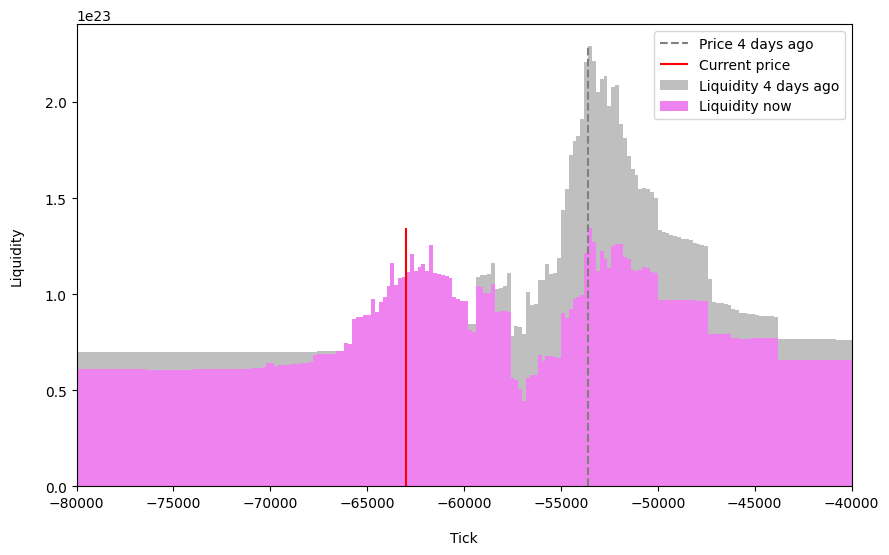

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    tick_liquidity_past_snap["tick"],
    tick_liquidity_past_snap["totalLiquidity"],
    width=tick_liquidity_past_snap["tick_width"],
    align="edge",
    alpha=0.5,
    color="gray",
    label="Liquidity 4 days ago",
)
ax.vlines(
    last_tick_past_snap,
    0,
    tick_liquidity_past_snap["totalLiquidity"].max(),
    color="gray",
    linestyle="--",
    alpha=1,
    label="Price 4 days ago",
)

ax.bar(
    tick_liquidity["tick"],
    tick_liquidity["totalLiquidity"],
    width=tick_liquidity["tick_width"],
    align="edge",
    alpha=1,
    color="violet",
    label="Liquidity now",
)
ax.vlines(
    last_tick,
    0,
    tick_liquidity["totalLiquidity"].max(),
    color="red",
    alpha=1,
    label="Current price",
)

ax.set_xlim(-8e4, -4e4)
ax.legend()

ax.set_ylabel("Liquidity", labelpad=15)
ax.set_xlabel("Tick", labelpad=15)